# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


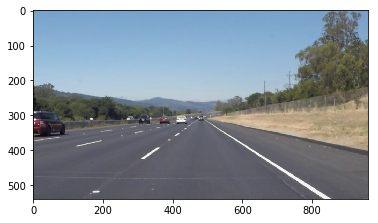

In [48]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [99]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Declare Left and Right Lanes
    left_lanes = []
    right_lanes = []
    left_slope = 0
    right_slope = 0
    
    # setting the Right Bottom of image as initial values
    left_x_top = img.shape[1]  
    left_y_top = img.shape[0]
    right_x_top = img.shape[1]
    right_y_top = img.shape[0]
    
    # use the slope to separate the lanes accordingly
    # and find the average slope and top most point of lane lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            
            # Segregate the line as left and right lane, based on the slope 
            if (slope<0):
                left_lanes.append(line)
                left_slope = left_slope + slope
                
                # Handle if the up and down co-ordinates are interchanged for a line
                if (y2 < y1):
                    if (y2 < left_y_top):
                        left_y_top = y2
                        left_x_top = x2
                else:
                    if (y1 < left_y_top):
                        left_y_top = y1
                        left_x_top = x1
            else:
                right_lanes.append(line)
                right_slope = right_slope + slope
                
                # Handle if the up and down co-ordinates are interchanged for a line
                if (y2 < y1):
                    if (y2 < right_y_top):
                        right_y_top = y2
                        right_x_top = x2
                else:
                    if (y1 < right_y_top):
                        right_y_top = y1
                        right_x_top = x1
                
    
    print ("The 2 top co-ordinates are :", left_x_top, left_y_top, right_x_top, right_y_top)
    #cv2.line(img, (left_x_top, left_y_top), (right_x_top, right_y_top), [0,255,0], 30)
    
    
    # find the average slope of both the lanes
    try :
        left_average_slope = left_slope/len(left_lanes)
        print ("Average Left lane slope :", left_average_slope)
    except(ZeroDivisionError):
        print ("No Left lane found")  #to-do : Handle the exception upon further calculation
    
    try:
        right_average_slope = right_slope/len(right_lanes)
        print ( "Average Right lane slope :",  right_average_slope)
    except(ZeroDivisionError):
        print ("No Right Lane found")   #to-do : Handle the exception upon further calculation
    
    
    # Now we have the top most co-ordinate of the lane, and the slop of the lane      
    # It's time to find out the bottom co-ordinate, to draw single lane line
    
    # Left-Bottom Co-ordinate, using the function y=mx+b
    # left_y_top = left_average_slope*left_x_top + b
    try:
        b = left_y_top - (left_average_slope*left_x_top)
        left_y_bottom = img.shape[0]
        left_x_bottom = int((left_y_bottom - b) /left_average_slope)   # re-arrange (y=mx+b)

        cv2.line(img, (left_x_top, left_y_top), (left_x_bottom, left_y_bottom), [255,0,0], 15)
    
    except(UnboundLocalError):
        print ("No Left Lane found in this frame..!")
    
    
    # In a Similar Way, finding the Right Bottom Co-ordinate
    try :
        b = right_y_top - (right_average_slope*right_x_top)
        right_y_bottom = img.shape[0]
        right_x_bottom = int((right_y_bottom - b) /right_average_slope)   # re-arrange (y=mx+b)

        cv2.line(img, (right_x_top, right_y_top), (right_x_bottom, right_y_bottom), [255,0,0], 15)    
    
    except(UnboundLocalError):
        print ("No Right Lane found in this Frame..!")
    
    print ("Left lanes :",len(left_lanes),"  Right lanes : ",len(right_lanes))

    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [53]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
#plt.imshow(image)


def draw_lane_lines(input_image):
    """
    This Function takes in the coloured image as input, 
    finds the lane in the image using all the helper functions, and draws the lane over the coloured image,
    and gives back the resultant image.
    """
    
    #fetch the image shape, and take a copy of the image to work on
    ysize = input_image.shape[0]
    xsize = input_image.shape[1]
    copy_image = np.copy(input_image)
    
    # convert the image to grayscale, and use gaussian blur to smoothen it
    gray_image = grayscale(copy_image)
    arbitrary_kernal_size = 5
    blurred_gray_image = gaussian_blur(gray_image, arbitrary_kernal_size)

    # use canny edge detection method to find the edges of the grayscled image
    arbitrary_low_threshold = 50
    arbitrary_high_threshold = 150
    edge_detected_image = canny(blurred_gray_image, arbitrary_low_threshold, arbitrary_high_threshold)

    # Mask the parts of the image other than lane, using RoI helper function
    mask = np.zeros_like(edge_detected_image)   
    ignore_mask_color = 255  
    imshape = copy_image.shape
    vertices = np.array([[(0,imshape[0]),(435, 330), (525,330), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edge_detected_image, mask)

    # applying hough lines
    # Define the Hough transform parameters
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 40
    max_line_gap = 20
    image_with_hough_line = hough_lines(masked_edges,rho, theta, threshold, min_line_length, max_line_gap)
    
    # The Final image is made by overlaying the hough lines over original image
    final_image = weighted_img(image_with_hough_line, copy_image)
    return final_image


solidYellowCurve.jpg
The 2 top co-ordinates are : 445 330 512 330
Average Left lane slope : -0.753778812573
Average Right lane slope : 0.57489626562
Left lanes : 13   Right lanes :  8


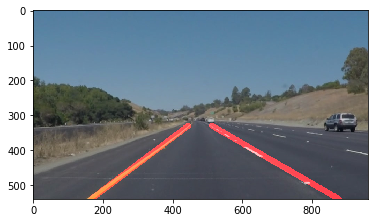

In [93]:
def iterate_test_image():
    tes_images_list = os.listdir("test_images/")
    for each_image in tes_images_list:
        print (each_image)
        test_output = draw_lane_lines(mpimg.imread('test_images/'+each_image))
        plt.imshow(test_output)
        mpimg.imsave("test_images_output/"+"output_Solid_"+each_image, test_output)
        break
        
iterate_test_image()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [57]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [58]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    result = draw_lane_lines(image)
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [100]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

The 2 top co-ordinates are : 441 330 524 330
Average Left lane slope : -0.729023920952
Average Right lane slope : 0.615489914656
Left lanes : 9   Right lanes :  7
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  2%|▏         | 4/222 [00:00<00:06, 32.07it/s]

The 2 top co-ordinates are : 441 330 524 330
Average Left lane slope : -0.729023920952
Average Right lane slope : 0.615489914656
Left lanes : 9   Right lanes :  7
The 2 top co-ordinates are : 442 330 523 330
Average Left lane slope : -0.737198352758
Average Right lane slope : 0.61456677348
Left lanes : 9   Right lanes :  10
The 2 top co-ordinates are : 441 330 523 330
Average Left lane slope : -0.753900436481
Average Right lane slope : 0.607139991819
Left lanes : 7   Right lanes :  9
The 2 top co-ordinates are : 441 331 523 330
Average Left lane slope : -0.732554680042
Average Right lane slope : 0.610329539833
Left lanes : 8   Right lanes :  6
The 2 top co-ordinates are : 442 331 523 330
Average Left lane slope : -0.703496612489
Average Right lane slope : 0.611459872065
Left lanes : 5   Right lanes :  8
The 2 top co-ordinates are : 443 330 524 330
Average Left lane slope : -0.724848961508
Average Right lane slope : 0.613856102315
Left lanes : 5   Right lanes :  10


The 2 top co-ordinates are : 441 332 518 330
Average Left lane slope : -0.69810298103
Average Right lane slope : 0.618769850269
Left lanes : 2   Right lanes :  6



  5%|▌         | 12/222 [00:00<00:06, 33.26it/s]

The 2 top co-ordinates are : 442 330 518 330
Average Left lane slope : -0.71665172529
Average Right lane slope : 0.607858508897
Left lanes : 3   Right lanes :  8
The 2 top co-ordinates are : 442 330 525 330
Average Left lane slope : -0.721981447635
Average Right lane slope : 0.611585920879
Left lanes : 6   Right lanes :  8
The 2 top co-ordinates are : 445 332 514 330
Average Left lane slope : -0.698831818298
Average Right lane slope : 0.602632799582
Left lanes : 5   Right lanes :  9
The 2 top co-ordinates are : 445 331 515 333
Average Left lane slope : -0.723820903998
Average Right lane slope : 0.615876080411
Left lanes : 7   Right lanes :  7
The 2 top co-ordinates are : 453 330 516 330
Average Left lane slope : -0.695743398124
Average Right lane slope : 0.631287215366
Left lanes : 8   Right lanes :  7
The 2 top co-ordinates are : 444 332 511 330
Average Left lane slope : -0.718348337868
Average Right lane slope : 0.635201402805
Left lanes : 11   Right lanes :  8
The 2 top co-ordinates


  9%|▉         | 20/222 [00:00<00:06, 33.39it/s]

The 2 top co-ordinates are : 444 332 523 330
Average Left lane slope : -0.690104436811
Average Right lane slope : 0.628232749493
Left lanes : 7   Right lanes :  7
The 2 top co-ordinates are : 443 330 525 330
Average Left lane slope : -0.710115632343
Average Right lane slope : 0.637991479237
Left lanes : 9   Right lanes :  7
The 2 top co-ordinates are : 442 331 521 330
Average Left lane slope : -0.706045014308
Average Right lane slope : 0.636479166568
Left lanes : 4   Right lanes :  6
The 2 top co-ordinates are : 442 330 526 331
Average Left lane slope : -0.723379495923
Average Right lane slope : 0.63755627142
Left lanes : 4   Right lanes :  6
The 2 top co-ordinates are : 441 330 523 330
Average Left lane slope : -0.711742424242
Average Right lane slope : 0.637456493841
Left lanes : 4   Right lanes :  6
The 2 top co-ordinates are : 448 330 521 330
Average Left lane slope : -0.688472953537
Average Right lane slope : 0.642219598563
Left lanes : 6   Right lanes :  6
The 2 top co-ordinates 


 11%|█         | 24/222 [00:00<00:05, 33.05it/s]

The 2 top co-ordinates are : 448 330 515 330
Average Left lane slope : -0.70732566698
Average Right lane slope : 0.62299485548
Left lanes : 10   Right lanes :  12
The 2 top co-ordinates are : 444 330 520 330
Average Left lane slope : -0.714467391716
Average Right lane slope : 0.64192726833
Left lanes : 8   Right lanes :  6
The 2 top co-ordinates are : 446 330 521 330
Average Left lane slope : -0.695163640772
Average Right lane slope : 0.630439840578
Left lanes : 7   Right lanes :  7
The 2 top co-ordinates are : 441 331 516 330
Average Left lane slope : -0.72541104558
Average Right lane slope : 0.637695263822
Left lanes : 11   Right lanes :  7
The 2 top co-ordinates are : 445 330 522 330
Average Left lane slope : -0.703068383815
Average Right lane slope : 0.640518124123
Left lanes : 9   Right lanes :  5
The 2 top co-ordinates are : 444 330 522 330
Average Left lane slope : -0.696198294921
Average Right lane slope : 0.638813017554
Left lanes : 9   Right lanes :  4



 13%|█▎        | 28/222 [00:00<00:05, 33.13it/s]

The 2 top co-ordinates are : 443 331 522 330
Average Left lane slope : -0.696101090411
Average Right lane slope : 0.633145157839
Left lanes : 5   Right lanes :  7



 14%|█▍        | 32/222 [00:00<00:05, 33.20it/s]

The 2 top co-ordinates are : 442 332 535 339
Average Left lane slope : -0.71809589482
Average Right lane slope : 0.63760622836
Left lanes : 4   Right lanes :  5
The 2 top co-ordinates are : 438 332 523 330
Average Left lane slope : -0.727326394034
Average Right lane slope : 0.63752177243
Left lanes : 5   Right lanes :  6
The 2 top co-ordinates are : 439 332 518 330
Average Left lane slope : -0.691893567336
Average Right lane slope : 0.634722037
Left lanes : 4   Right lanes :  6
The 2 top co-ordinates are : 438 332 519 330
Average Left lane slope : -0.756804230622
Average Right lane slope : 0.648854002689
Left lanes : 5   Right lanes :  8
The 2 top co-ordinates are : 435 333 525 330
Average Left lane slope : -0.713272624146
Average Right lane slope : 0.642759952556
Left lanes : 7   Right lanes :  6
The 2 top co-ordinates are : 437 334 518 330
Average Left lane slope : -0.692106869738
Average Right lane slope : 0.624013380829
Left lanes : 3   Right lanes :  8


The 2 top co-ordinates are : 446 330 552 350
Average Left lane slope : -0.725363583215
Average Right lane slope : 0.639108146176
Left lanes : 8   Right lanes :  6



 18%|█▊        | 40/222 [00:01<00:05, 33.18it/s]

The 2 top co-ordinates are : 447 330 515 330
Average Left lane slope : -0.714200970924
Average Right lane slope : 0.629348256138
Left lanes : 8   Right lanes :  6
The 2 top co-ordinates are : 443 330 515 330
Average Left lane slope : -0.699588425085
Average Right lane slope : 0.639778880493
Left lanes : 7   Right lanes :  6
The 2 top co-ordinates are : 443 330 518 330
Average Left lane slope : -0.73205772309
Average Right lane slope : 0.659159212588
Left lanes : 7   Right lanes :  9
The 2 top co-ordinates are : 444 330 519 330
Average Left lane slope : -0.731245738677
Average Right lane slope : 0.640092346842
Left lanes : 8   Right lanes :  7
The 2 top co-ordinates are : 444 330 520 330
Average Left lane slope : -0.734731007371
Average Right lane slope : 0.644335761074
Left lanes : 7   Right lanes :  7
The 2 top co-ordinates are : 440 330 526 331
Average Left lane slope : -0.701756629556
Average Right lane slope : 0.650305938816
Left lanes : 5   Right lanes :  9
The 2 top co-ordinates 

The 2 top co-ordinates are : 437 331 521 330
Average Left lane slope : -0.732269503546
Average Right lane slope : 0.654473611668
Left lanes : 3   Right lanes :  5
The 2 top co-ordinates are : 437 331 521 330
Average Left lane slope : -0.717867677474
Average Right lane slope : 0.655186570459
Left lanes : 5   Right lanes :  8



 20%|█▉        | 44/222 [00:01<00:07, 22.76it/s]

The 2 top co-ordinates are : 435 332 520 330
Average Left lane slope : -0.735377241806
Average Right lane slope : 0.644534610071
Left lanes : 7   Right lanes :  6
The 2 top co-ordinates are : 437 333 519 330
Average Left lane slope : -0.740982142857
Average Right lane slope : 0.652342209786
Left lanes : 4   Right lanes :  8


The 2 top co-ordinates are : 433 333 528 331
Average Left lane slope : -0.724903661228
Average Right lane slope : 0.656995969058
Left lanes : 7   Right lanes :  7



 21%|██        | 47/222 [00:01<00:09, 18.33it/s]

The 2 top co-ordinates are : 323 412 519 330
Average Left lane slope : -0.74691195365
Average Right lane slope : 0.662498474574
Left lanes : 5   Right lanes :  7
The 2 top co-ordinates are : 444 330 523 330
Average Left lane slope : -0.711002057685
Average Right lane slope : 0.647716650728
Left lanes : 9   Right lanes :  5



 23%|██▎       | 50/222 [00:01<00:10, 17.00it/s]

The 2 top co-ordinates are : 444 330 523 330
Average Left lane slope : -0.718315679263
Average Right lane slope : 0.648918248797
Left lanes : 8   Right lanes :  10
The 2 top co-ordinates are : 440 332 519 330
Average Left lane slope : -0.726543949942
Average Right lane slope : 0.638398211872
Left lanes : 7   Right lanes :  6
The 2 top co-ordinates are : 438 331 519 330
Average Left lane slope : -0.728743720313
Average Right lane slope : 0.6586619287
Left lanes : 9   Right lanes :  8



 24%|██▍       | 53/222 [00:02<00:10, 15.81it/s]

The 2 top co-ordinates are : 440 330 523 330
Average Left lane slope : -0.7
Average Right lane slope : 0.649149861166
Left lanes : 2   Right lanes :  7



 25%|██▍       | 55/222 [00:02<00:10, 15.32it/s]

The 2 top co-ordinates are : 438 330 523 330
Average Left lane slope : -0.702814645309
Average Right lane slope : 0.649566947766
Left lanes : 5   Right lanes :  8
The 2 top co-ordinates are : 439 332 522 330
Average Left lane slope : -0.676964769648
Average Right lane slope : 0.641736920481
Left lanes : 2   Right lanes :  6


The 2 top co-ordinates are : 434 333 521 330
Average Left lane slope : -0.703381642512
Average Right lane slope : 0.6576940972
Left lanes : 2   Right lanes :  9
The 2 top co-ordinates are : 446 330 519 330
Average Left lane slope : -0.709363541547
Average Right lane slope : 0.623189457049
Left lanes : 5   Right lanes :  13



 26%|██▌       | 57/222 [00:02<00:11, 14.75it/s]

The 2 top co-ordinates are : 443 330 517 330
Average Left lane slope : -0.670359204066
Average Right lane slope : 0.640556619182
Left lanes : 5   Right lanes :  7



 27%|██▋       | 59/222 [00:02<00:11, 14.46it/s]

The 2 top co-ordinates are : 442 330 518 330
Average Left lane slope : -0.704141808513
Average Right lane slope : 0.643238176611
Left lanes : 6   Right lanes :  8
The 2 top co-ordinates are : 444 330 531 337
Average Left lane slope : -0.677631657003
Average Right lane slope : 0.656060838735
Left lanes : 7   Right lanes :  6



 27%|██▋       | 61/222 [00:02<00:11, 14.04it/s]

The 2 top co-ordinates are : 441 330 513 330
Average Left lane slope : -0.684498605159
Average Right lane slope : 0.663039005434
Left lanes : 11   Right lanes :  8


The 2 top co-ordinates are : 441 330 517 330
Average Left lane slope : -0.703627158625
Average Right lane slope : 0.653037748628
Left lanes : 12   Right lanes :  9
The 2 top co-ordinates are : 440 331 513 330
Average Left lane slope : -0.689765635935
Average Right lane slope : 0.658965520889
Left lanes : 7   Right lanes :  8



 28%|██▊       | 63/222 [00:02<00:11, 13.68it/s]

The 2 top co-ordinates are : 440 332 512 330
Average Left lane slope : -0.676733354029
Average Right lane slope : 0.639235155714
Left lanes : 8   Right lanes :  9



 29%|██▉       | 65/222 [00:03<00:11, 13.65it/s]

The 2 top co-ordinates are : 442 330 512 330
Average Left lane slope : -0.67468144851
Average Right lane slope : 0.633177427238
Left lanes : 6   Right lanes :  7
The 2 top co-ordinates are : 439 333 512 330
Average Left lane slope : -0.665115282592
Average Right lane slope : 0.632945083444
Left lanes : 4   Right lanes :  8
The 2 top co-ordinates are :


 30%|███       | 67/222 [00:03<00:11, 13.61it/s]

 438 330 515 330
Average Left lane slope : -0.682291666667
Average Right lane slope : 0.66496926923
Left lanes : 2   Right lanes :  9


The 2 top co-ordinates are : 433 333 513 330
Average Left lane slope : -0.67962962963
Average Right lane slope : 0.648450364012
Left lanes : 3   Right lanes :  10
The 2 top co-ordinates are : 444 330 520 330
Average Left lane slope : -0.683432984858
Average Right lane slope : 0.661797967525
Left lanes : 7   Right lanes :  8



 31%|███       | 69/222 [00:03<00:11, 13.47it/s]

The 2 top co-ordinates are : 442 330 519 330
Average Left lane slope : -0.674302506798
Average Right lane slope : 0.657273911835
Left lanes : 7   Right lanes :  6



 32%|███▏      | 71/222 [00:03<00:11, 13.63it/s]

The 2 top co-ordinates are : 441 330 513 330
Average Left lane slope : -0.678791028668
Average Right lane slope : 0.660461709502
Left lanes : 5   Right lanes :  6
The 2 top co-ordinates are : 440 331 519 330
Average Left lane slope : -0.686591187522
Average Right lane slope : 0.653533685599
Left lanes : 7   Right lanes :  8



 33%|███▎      | 73/222 [00:03<00:11, 13.51it/s]

The 2 top co-ordinates are : 443 330 514 330
Average Left lane slope : -0.673876384511
Average Right lane slope : 0.660233895145
Left lanes : 10   Right lanes :  6


The 2 top co-ordinates are : 437 331 513 330
Average Left lane slope : -0.660363413989
Average Right lane slope : 0.656050334845
Left lanes : 9   Right lanes :  6
The 2 top co-ordinates are : 438 330 519 330
Average Left lane slope : -0.67690317985
Average Right lane slope : 0.65724928212
Left lanes : 7   Right lanes :  8



 34%|███▍      | 75/222 [00:03<00:11, 12.96it/s]

The 2 top co-ordinates are : 440 330 519 330
Average Left lane slope : -0.679110369227
Average Right lane slope : 0.663440358599
Left lanes : 9   Right lanes :  7



 35%|███▍      | 77/222 [00:03<00:11, 13.01it/s]

The 2 top co-ordinates are : 439 330 519 330
Average Left lane slope : -0.657089924036
Average Right lane slope : 0.675134549757
Left lanes : 5   Right lanes :  11
The 2 top co-ordinates are : 438 331 515 330
Average Left lane slope : -0.691019407561
Average Right lane slope : 0.657641658064
Left lanes : 5   Right lanes :  10
The 2 top co-ordinates are : 438 330 514 330
Average Left lane slope : -0.678557355847
Average Right lane slope : 0.681950901209
Left lanes : 6   Right lanes :  6



 36%|███▌      | 79/222 [00:04<00:10, 13.02it/s]

The 2 top co-ordinates are : 433 333 514 330
Average Left lane slope : -0.673967005859
Average Right lane slope : 0.679003745189
Left lanes : 5   Right lanes :  8
The 2 top co-ordinates are : 431 333 520 330
Average Left lane slope : -0.667379546686
Average Right lane slope : 0.672017663131
Left lanes : 9   Right lanes :  7



 36%|███▋      | 81/222 [00:04<00:10, 13.09it/s]

The 2 top co-ordinates are : 432 334 514 330
Average Left lane slope : -0.646732438099
Average Right lane slope : 0.677050227347
Left lanes : 6   Right lanes :  8



 37%|███▋      | 83/222 [00:04<00:10, 13.18it/s]

The 2 top co-ordinates are : 442 330 514 330
Average Left lane slope : -0.655731450262
Average Right lane slope : 0.68621967672
Left lanes : 8   Right lanes :  8
The 2 top co-ordinates are : 428 336 515 330
Average Left lane slope : -0.653720849694
Average Right lane slope : 0.689717926029
Left lanes : 7   Right lanes :  9



 38%|███▊      | 85/222 [00:04<00:10, 13.29it/s]

The 2 top co-ordinates are : 442 330 518 333
Average Left lane slope : -0.642724101144
Average Right lane slope : 0.67315010094
Left lanes : 9   Right lanes :  7



 39%|███▉      | 87/222 [00:04<00:10, 13.36it/s]

The 2 top co-ordinates are : 438 332 516 331
Average Left lane slope : -0.662488120253
Average Right lane slope : 0.690836588579
Left lanes : 8   Right lanes :  9
The 2 top co-ordinates are : 437 330 516 331
Average Left lane slope : -0.645093598804
Average Right lane slope : 0.672494264638
Left lanes : 8   Right lanes :  8


The 2 top co-ordinates are : 439 330 516 331
Average Left lane slope : -0.647891848264
Average Right lane slope : 0.663073437437
Left lanes : 7   Right lanes :  7



 40%|████      | 89/222 [00:04<00:09, 13.38it/s]

The 2 top co-ordinates are : 439 331 515 330
Average Left lane slope : -0.660190326914
Average Right lane slope : 0.667062422292
Left lanes : 5   Right lanes :  8
The 2 top co-ordinates are : 438 331 515 330
Average Left lane slope : -0.649599107462
Average Right lane slope : 0.679165098019
Left lanes : 5   Right lanes :  10



 41%|████      | 91/222 [00:05<00:09, 13.54it/s]

The 2 top co-ordinates are : 440 330 515 330
Average Left lane slope : -0.668964299193
Average Right lane slope : 0.702552784006
Left lanes : 4   Right lanes :  10



 42%|████▏     | 93/222 [00:05<00:09, 13.45it/s]

The 2 top co-ordinates are : 448 330 515 330
Average Left lane slope : -0.647350806453
Average Right lane slope : 0.707731848055
Left lanes : 6   Right lanes :  12
The 2 top co-ordinates are : 445 330 517 330
Average Left lane slope : -0.676694400932
Average Right lane slope : 0.693091153977
Left lanes : 7   Right lanes :  6


The 2 top co-ordinates are : 447 330 521 332
Average Left lane slope : -0.663539449651
Average Right lane slope : 0.709068009531
Left lanes : 6   Right lanes :  7



 43%|████▎     | 95/222 [00:05<00:09, 13.52it/s]

The 2 top co-ordinates are : 444 330 525 330
Average Left lane slope : -0.654776218245
Average Right lane slope : 0.693563588939
Left lanes : 8   Right lanes :  10
The 2 top co-ordinates are : 445 330 519 330
Average Left lane slope : -0.647577306273
Average Right lane slope : 0.689046245988
Left lanes : 7   Right lanes :  8
The 2 top co-ordinates are :


 44%|████▎     | 97/222 [00:05<00:09, 13.48it/s]

 442 330 520 330
Average Left lane slope : -0.671476238886
Average Right lane slope : 0.701947830535
Left lanes : 8   Right lanes :  9


The 2 top co-ordinates are : 445 330 521 330
Average Left lane slope : -0.671708248637
Average Right lane slope : 0.701109832621
Left lanes : 10   Right lanes :  7
The 2 top co-ordinates are : 441 330 523 330
Average Left lane slope : -0.644977721699
Average Right lane slope : 0.712186571428
Left lanes : 9   Right lanes :  5



 45%|████▍     | 99/222 [00:05<00:09, 13.36it/s]

The 2 top co-ordinates are : 440 330 524 330
Average Left lane slope : -0.663569071866
Average Right lane slope : 0.691322718214
Left lanes : 7   Right lanes :  7



 45%|████▌     | 101/222 [00:05<00:09, 13.39it/s]

The 2 top co-ordinates are : 439 330 522 330
Average Left lane slope : -0.679100557665
Average Right lane slope : 0.702757616424
Left lanes : 5   Right lanes :  6
The 2 top co-ordinates are : 443 331 520 330
Average Left lane slope : -0.70213952714
Average Right lane slope : 0.70872091488
Left lanes : 4   Right lanes :  8



 46%|████▋     | 103/222 [00:05<00:08, 13.38it/s]

The 2 top co-ordinates are : 444 330 524 330
Average Left lane slope : -0.629968159859
Average Right lane slope : 0.688868482262
Left lanes : 3   Right lanes :  6



 47%|████▋     | 105/222 [00:06<00:08, 13.48it/s]

The 2 top co-ordinates are : 450 330 518 330
Average Left lane slope : -0.651811138456
Average Right lane slope : 0.686990091548
Left lanes : 6   Right lanes :  8
The 2 top co-ordinates are : 448 330 518 330
Average Left lane slope : -0.671324457389
Average Right lane slope : 0.68768507608
Left lanes : 6   Right lanes :  12


The 2 top co-ordinates are : 448 330 525 330
Average Left lane slope : -0.664985773022
Average Right lane slope : 0.682738909077
Left lanes : 8   Right lanes :  7



 48%|████▊     | 107/222 [00:06<00:08, 13.19it/s]

The 2 top co-ordinates are : 447 330 526 330
Average Left lane slope : -0.68671104204
Average Right lane slope : 0.664857620016
Left lanes : 7   Right lanes :  9
The 2 top co-ordinates are : 449 330 520 330
Average Left lane slope : -0.660143451049
Average Right lane slope : 0.679024579032
Left lanes : 7   Right lanes :  6



 49%|████▉     | 109/222 [00:06<00:08, 13.29it/s]

The 2 top co-ordinates are : 444 330 530 332
Average Left lane slope : -0.677883145521
Average Right lane slope : 0.691389085155
Left lanes : 7   Right lanes :  6



 50%|█████     | 111/222 [00:06<00:08, 13.42it/s]

The 2 top co-ordinates are : 444 330 526 330
Average Left lane slope : -0.691981003994
Average Right lane slope : 0.68690315301
Left lanes : 10   Right lanes :  6
The 2 top co-ordinates are : 445 330 519 330
Average Left lane slope : -0.693452139624
Average Right lane slope : 0.682740063726
Left lanes : 9   Right lanes :  5


The 2 top co-ordinates are : 445 331 525 331
Average Left lane slope : -0.696380810056
Average Right lane slope : 0.690055376689
Left lanes : 8   Right lanes :  9
The 2 top co-ordinates are :


 51%|█████     | 113/222 [00:06<00:08, 13.39it/s]

 441 331 526 330
Average Left lane slope : -0.697461386852
Average Right lane slope : 0.683303259361
Left lanes : 6   Right lanes :  5
The 2 top co-ordinates are : 444 330 526 330
Average Left lane slope : -0.670885815572
Average Right lane slope : 0.681024394675
Left lanes : 5   Right lanes :  5



 52%|█████▏    | 115/222 [00:06<00:07, 13.51it/s]

The 2 top co-ordinates are : 439 332 528 331
Average Left lane slope : -0.705251960222
Average Right lane slope : 0.671000180266
Left lanes : 6   Right lanes :  6



 53%|█████▎    | 117/222 [00:06<00:07, 13.67it/s]

The 2 top co-ordinates are : 441 332 532 333
Average Left lane slope : -0.692222222222
Average Right lane slope : 0.676647586342
Left lanes : 5   Right lanes :  6
The 2 top co-ordinates are : 439 333 525 330
Average Left lane slope : -0.669330844153
Average Right lane slope : 0.669192457273
Left lanes : 7   Right lanes :  7


The 2 top co-ordinates are : 447 330 526 330
Average Left lane slope : -0.67935821497
Average Right lane slope : 0.668304024395
Left lanes : 8   Right lanes :  6
The 2 top co-ordinates are : 446 330 526 330
Average Left lane slope : -0.645050351586
Average Right lane slope : 0.656669803178
Left lanes : 5   Right lanes :  7



 54%|█████▎    | 119/222 [00:07<00:07, 13.78it/s]

The 2 top co-ordinates are : 445 330 518 330
Average Left lane slope : -0.669289478473
Average Right lane slope : 0.671269333966
Left lanes : 7   Right lanes :  8
The 2 top co-ordinates are : 


 55%|█████▍    | 121/222 [00:07<00:07, 13.83it/s]

448 330 518 330
Average Left lane slope : -0.672952054596
Average Right lane slope : 0.639458234745
Left lanes : 8   Right lanes :  7
The 2 top co-ordinates are : 444 331 522 330
Average Left lane slope : -0.680210944275
Average Right lane slope : 0.652389144224
Left lanes : 8   Right lanes :  9
The 2 top co-ordinates are : 445 331 524 331
Average Left lane slope : -0.690281511336
Average Right lane slope : 0.637031493165
Left lanes : 8   Right lanes :  6



 56%|█████▋    | 125/222 [00:07<00:06, 14.15it/s]

The 2 top co-ordinates are : 444 332 518 330
Average Left lane slope : -0.671967655514
Average Right lane slope : 0.640295236822
Left lanes : 6   Right lanes :  7
The 2 top co-ordinates are : 445 332 520 330
Average Left lane slope : -0.684807488491
Average Right lane slope : 0.645272296256
Left lanes : 8   Right lanes :  11
The 2 top co-ordinates are : 443 332 525 330
Average Left lane slope : -0.696350916998
Average Right lane slope : 0.640451912355
Left lanes : 3   Right lanes :  7
The 2 top co-ordinates are : 444 333 519 330
Average Left lane slope : -0.681188146649
Average Right lane slope : 0.640919515042
Left lanes : 4   Right lanes :  8



 58%|█████▊    | 129/222 [00:07<00:06, 14.38it/s]

The 2 top co-ordinates are : 447 330 525 330
Average Left lane slope : -0.679437818831
Average Right lane slope : 0.640869421435
Left lanes : 4   Right lanes :  7
The 2 top co-ordinates are : 453 330 519 330
Average Left lane slope : -0.716998516952
Average Right lane slope : 0.635036013891
Left lanes : 6   Right lanes :  5
The 2 top co-ordinates are : 453 330 519 330
Average Left lane slope : -0.696767232101
Average Right lane slope : 0.64941206674
Left lanes : 6   Right lanes :  9
The 2 top co-ordinates are : 453 331


 59%|█████▉    | 131/222 [00:07<00:06, 14.25it/s]

 518 330
Average Left lane slope : -0.687819832066
Average Right lane slope : 0.63437140916
Left lanes : 5   Right lanes :  8
The 2 top co-ordinates are : 448 330 518 330
Average Left lane slope : -0.699731640436
Average Right lane slope : 0.637798827048
Left lanes : 8   Right lanes :  6
The 2 top co-ordinates are : 448 330 518 330
Average Left lane slope : -0.72619361815
Average Right lane slope : 0.644027890223
Left lanes : 7   Right lanes :  8



 61%|██████    | 135/222 [00:08<00:06, 13.36it/s]

The 2 top co-ordinates are : 450 330 526 330
Average Left lane slope : -0.714641899935
Average Right lane slope : 0.625543484636
Left lanes : 9   Right lanes :  7
The 2 top co-ordinates are : 444 330 522 330
Average Left lane slope : -0.694157488855
Average Right lane slope : 0.619259220667
Left lanes : 9   Right lanes :  11
The 2 top co-ordinates are : 448 330 523 330
Average Left lane slope : -0.71338641012
Average Right lane slope : 0.636244448386
Left lanes : 8   Right lanes :  10
The 2 top co-ordinates are :


 63%|██████▎   | 139/222 [00:08<00:06, 13.58it/s]

 442 330 523 330
Average Left lane slope : -0.691981024736
Average Right lane slope : 0.632491601528
Left lanes : 9   Right lanes :  8
The 2 top co-ordinates are : 445 330 523 330
Average Left lane slope : -0.678343099692
Average Right lane slope : 0.636684037136
Left lanes : 4   Right lanes :  8
The 2 top co-ordinates are : 443 331 521 330
Average Left lane slope : -0.715940564045
Average Right lane slope : 0.63183919383
Left lanes : 4   Right lanes :  7



 64%|██████▎   | 141/222 [00:08<00:05, 13.66it/s]

The 2 top co-ordinates are : 452 330 519 330
Average Left lane slope : -0.704257123474
Average Right lane slope : 0.640703570622
Left lanes : 4   Right lanes :  6
The 2 top co-ordinates are : 450 330 525 330
Average Left lane slope : -0.71832096475
Average Right lane slope : 0.636434960298
Left lanes : 5   Right lanes :  6
The 2 top co-ordinates are : 453 330 524 330
Average Left lane slope : -0.713428360935
Average Right lane slope : 0.632438355035
Left lanes : 6   Right lanes :  6
The 2 top co-ordinates are :


 64%|██████▍   | 143/222 [00:08<00:05, 13.85it/s]

 452 330 523 330
Average Left lane slope : -0.715934786117
Average Right lane slope : 0.630098527389
Left lanes : 9   Right lanes :  5
The 2 top co-ordinates are : 448 330 523 330
Average Left lane slope : -0.725744534156
Average Right lane slope : 0.612117448413
Left lanes : 7   Right lanes :  10
The 2 top co-ordinates are : 451 331 524 330
Average Left lane slope : -0.713896066712
Average Right lane slope : 0.633948407042
Left lanes : 6   Right lanes :  6



 66%|██████▌   | 147/222 [00:09<00:05, 13.82it/s]

The 2 top co-ordinates are : 447 330 526 330
Average Left lane slope : -0.723489199561
Average Right lane slope : 0.636396238994
Left lanes : 9   Right lanes :  5
The 2 top co-ordinates are : 450 330 522 330
Average Left lane slope : -0.731852954244
Average Right lane slope : 0.621130171576
Left lanes : 10   Right lanes :  10
The 2 top co-ordinates are : 448 330 530 334
Average Left lane slope : -0.718530417447
Average Right lane slope : 0.638065716612
Left lanes : 9   Right lanes :  7



 68%|██████▊   | 151/222 [00:09<00:05, 13.86it/s]

The 2 top co-ordinates are : 445 330 527 332
Average Left lane slope : -0.736540330676
Average Right lane slope : 0.642566511015
Left lanes : 8   Right lanes :  12
The 2 top co-ordinates are : 446 331 523 330
Average Left lane slope : -0.714791323228
Average Right lane slope : 0.607288809312
Left lanes : 4   Right lanes :  9
The 2 top co-ordinates are : 446 332 530 332
Average Left lane slope : -0.702408489997
Average Right lane slope : 0.62363236175
Left lanes : 3   Right lanes :  8



 69%|██████▉   | 153/222 [00:09<00:04, 14.03it/s]

The 2 top co-ordinates are : 454 330 526 330
Average Left lane slope : -0.732035663223
Average Right lane slope : 0.607894361851
Left lanes : 5   Right lanes :  8
The 2 top co-ordinates are : 454 330 520 330
Average Left lane slope : -0.715436683171
Average Right lane slope : 0.615219725357
Left lanes : 3   Right lanes :  9
The 2 top co-ordinates are : 442 334 525 331
Average Left lane slope : -0.721000698879
Average Right lane slope : 0.634069193027
Left lanes : 6   Right lanes :  7



 71%|███████   | 157/222 [00:09<00:04, 14.35it/s]

The 2 top co-ordinates are : 452 330 523 331
Average Left lane slope : -0.706261263246
Average Right lane slope : 0.613658015187
Left lanes : 4   Right lanes :  7
The 2 top co-ordinates are : 452 330 546 340
Average Left lane slope : -0.721115072292
Average Right lane slope : 0.628581776023
Left lanes : 6   Right lanes :  7
The 2 top co-ordinates are : 449 330 544 339
Average Left lane slope : -0.718669947706
Average Right lane slope : 0.620141645889
Left lanes : 8   Right lanes :  5
The 2 top co-ordinates are : 447 330 523 330
Average Left lane slope : -0.73296567428
Average Right lane slope : 0.622402759248
Left lanes : 10   Right lanes :  9



 73%|███████▎  | 161/222 [00:10<00:04, 13.98it/s]

The 2 top co-ordinates are : 451 330 525 330
Average Left lane slope : -0.72634042764
Average Right lane slope : 0.605294880745
Left lanes : 10   Right lanes :  9
The 2 top co-ordinates are : 446 330 552 343
Average Left lane slope : -0.747725068193
Average Right lane slope : 0.610466383033
Left lanes : 11   Right lanes :  6
The 2 top co-ordinates are : 448 331 523 330
Average Left lane slope : -0.756578032445
Average Right lane slope : 0.597695036762
Left lanes : 7   Right lanes :  7



 73%|███████▎  | 163/222 [00:10<00:04, 13.95it/s]

The 2 top co-ordinates are : 447 332 523 330
Average Left lane slope : -0.733850026497
Average Right lane slope : 0.623627293796
Left lanes : 4   Right lanes :  10
The 2 top co-ordinates are : 449 330 522 330
Average Left lane slope : -0.770679537783
Average Right lane slope : 0.587594671664
Left lanes : 6   Right lanes :  8
The 2 top co-ordinates are : 454 330 521 330
Average Left lane slope : -0.74148422876
Average Right lane slope : 0.585106107477
Left lanes : 5   Right lanes :  8



 75%|███████▌  | 167/222 [00:10<00:04, 13.43it/s]

The 2 top co-ordinates are : 456 330 521 330
Average Left lane slope : -0.786777408638
Average Right lane slope : 0.604778644261
Left lanes : 4   Right lanes :  10
The 2 top co-ordinates are : 455 330 526 330
Average Left lane slope : -0.750416559127
Average Right lane slope : 0.590872772956
Left lanes : 8   Right lanes :  9
The 2 top co-ordinates are : 453 330 519 330
Average Left lane slope : -0.783758443815
Average Right lane slope : 0.591499511521
Left lanes : 7   Right lanes :  7



 76%|███████▌  | 169/222 [00:10<00:03, 13.59it/s]

The 2 top co-ordinates are : 452 330 518 330
Average Left lane slope : -0.76120992534
Average Right lane slope : 0.586323677849
Left lanes : 6   Right lanes :  4
The 2 top co-ordinates are : 450 330 524 330
Average Left lane slope : -0.807022600198
Average Right lane slope : 0.575675915548
Left lanes : 8   Right lanes :  8
The 2 top co-ordinates are : 447 331 518 330
Average Left lane slope : -0.755516918017
Average Right lane slope : 0.590604812409
Left lanes : 9   Right lanes :  4
The 2 top co-ordinates are : 


 78%|███████▊  | 173/222 [00:10<00:03, 13.94it/s]

451 331 519 330
Average Left lane slope : -0.787447511857
Average Right lane slope : 0.592079421725
Left lanes : 8   Right lanes :  6
The 2 top co-ordinates are : 449 332 530 337
Average Left lane slope : -0.766283139329
Average Right lane slope : 0.573782488252
Left lanes : 9   Right lanes :  7
The 2 top co-ordinates are : 446 332 526 330
Average Left lane slope : -0.779941567355
Average Right lane slope : 0.587092403299
Left lanes : 9   Right lanes :  7



 79%|███████▉  | 175/222 [00:11<00:03, 14.26it/s]

The 2 top co-ordinates are : 446 332 520 330
Average Left lane slope : -0.787214611872
Average Right lane slope : 0.583721638572
Left lanes : 3   Right lanes :  7
The 2 top co-ordinates are : 445 333 526 330
Average Left lane slope : -0.792128595461
Average Right lane slope : 0.589012651357
Left lanes : 4   Right lanes :  10
The 2 top co-ordinates are : 454 330 520 330
Average Left lane slope : -0.770551038844
Average Right lane slope : 0.580237997347
Left lanes : 3   Right lanes :  8



 81%|████████  | 179/222 [00:11<00:03, 14.25it/s]

The 2 top co-ordinates are : 455 330 521 330
Average Left lane slope : -0.773960695389
Average Right lane slope : 0.590602471405
Left lanes : 3   Right lanes :  7
The 2 top co-ordinates are : 452 330 530 332
Average Left lane slope : -0.79623279959
Average Right lane slope : 0.577029917706
Left lanes : 6   Right lanes :  9
The 2 top co-ordinates are : 451 330 521 330
Average Left lane slope : -0.818192175392
Average Right lane slope : 0.57736026097
Left lanes : 8   Right lanes :  10



 82%|████████▏ | 181/222 [00:11<00:03, 13.17it/s]

The 2 top co-ordinates are : 441 336 524 330
Average Left lane slope : -0.77703668585
Average Right lane slope : 0.609677640526
Left lanes : 5   Right lanes :  9
The 2 top co-ordinates are : 453 330 523 330
Average Left lane slope : -0.814582812723
Average Right lane slope : 0.590053802837
Left lanes : 9   Right lanes :  10
The 2 top co-ordinates are : 448 330 562 353
Average Left lane slope : -0.806274402556
Average Right lane slope : 0.586952177402
Left lanes : 7   Right lanes :  10



 83%|████████▎ | 185/222 [00:11<00:02, 13.78it/s]

The 2 top co-ordinates are : 452 330 523 330
Average Left lane slope : -0.802289611353
Average Right lane slope : 0.586748181958
Left lanes : 9   Right lanes :  7
The 2 top co-ordinates are : 448 330 539 338
Average Left lane slope : -0.766643894384
Average Right lane slope : 0.596623710446
Left lanes : 8   Right lanes :  11
The 2 top co-ordinates are : 447 330 524 330
Average Left lane slope : -0.800042808562
Average Right lane slope : 0.585402201047
Left lanes : 7   Right lanes :  9



 84%|████████▍ | 187/222 [00:12<00:02, 13.90it/s]

The 2 top co-ordinates are : 444 331 528 332
Average Left lane slope : -0.787864407663
Average Right lane slope : 0.585370713112
Left lanes : 4   Right lanes :  11
The 2 top co-ordinates are : 447 331 523 330
Average Left lane slope : -0.808220811491
Average Right lane slope : 0.582947089126
Left lanes : 6   Right lanes :  8
The 2 top co-ordinates are : 446 333 524 330
Average Left lane slope : -0.823397623222
Average Right lane slope : 0.590533795537
Left lanes : 3   Right lanes :  5
The 2 top co-ordinates are : 441 331 528 331
Average Left lane slope : -0.817554909561
Average Right lane slope : 0.586917309608
Left lanes : 4   Right lanes :  5



 86%|████████▌ | 191/222 [00:12<00:02, 14.21it/s]

The 2 top co-ordinates are : 444 330 557 345
Average Left lane slope : -0.792737369572
Average Right lane slope : 0.594523753616
Left lanes : 7   Right lanes :  7
The 2 top co-ordinates are : 441 331 548 341
Average Left lane slope : -0.821146940937
Average Right lane slope : 0.565842749867
Left lanes : 7   Right lanes :  9
The 2 top co-ordinates are : 442 334 523 330
Average Left lane slope : -0.787256293747
Average Right lane slope : 0.558140737179
Left lanes : 7   Right lanes :  10



 88%|████████▊ | 195/222 [00:12<00:01, 13.80it/s]

The 2 top co-ordinates are : 449 330 544 339
Average Left lane slope : -0.806678815378
Average Right lane slope : 0.587160550593
Left lanes : 8   Right lanes :  10
The 2 top co-ordinates are : 450 331 526 334
Average Left lane slope : -0.81511294815
Average Right lane slope : 0.58686842166
Left lanes : 9   Right lanes :  5
The 2 top co-ordinates are : 456 330 525 330
Average Left lane slope : -0.797579698626
Average Right lane slope : 0.590086841284
Left lanes : 10   Right lanes :  9



 89%|████████▊ | 197/222 [00:12<00:01, 13.81it/s]

The 2 top co-ordinates are : 457 330 522 330
Average Left lane slope : -0.776823948915
Average Right lane slope : 0.60875168454
Left lanes : 8   Right lanes :  8
The 2 top co-ordinates are : 445 332 518 330
Average Left lane slope : -0.815427071625
Average Right lane slope : 0.594381872556
Left lanes : 9   Right lanes :  7
The 2 top co-ordinates are : 454 330 525 330
Average Left lane slope : -0.802617120337
Average Right lane slope : 0.596720018947
Left lanes : 6   Right lanes :  10



 91%|█████████ | 201/222 [00:13<00:01, 13.64it/s]

The 2 top co-ordinates are : 444 332 526 330
Average Left lane slope : -0.820572728744
Average Right lane slope : 0.578804593532
Left lanes : 5   Right lanes :  13
The 2 top co-ordinates are : 451 330 524 330
Average Left lane slope : -0.822760737243
Average Right lane slope : 0.588440816585
Left lanes : 4   Right lanes :  6
The 2 top co-ordinates are : 451 330 525 330
Average Left lane slope : -0.630269937357
Average Right lane slope : 0.566082325334
Left lanes : 6   Right lanes :  7



 91%|█████████▏| 203/222 [00:13<00:01, 13.73it/s]

The 2 top co-ordinates are : 450 330 519 330
Average Left lane slope : -0.817062387918
Average Right lane slope : 0.57596526515
Left lanes : 5   Right lanes :  11
The 2 top co-ordinates are : 442 335 526 330
Average Left lane slope : -0.817855393811
Average Right lane slope : 0.562894533212
Left lanes : 5   Right lanes :  9
The 2 top co-ordinates are : 441 336 532 333
Average Left lane slope : -0.812409606806
Average Right lane slope : 0.572243287263
Left lanes : 5   Right lanes :  10



 93%|█████████▎| 207/222 [00:13<00:01, 14.18it/s]

The 2 top co-ordinates are : 449 330 524 330
Average Left lane slope : -0.807315112497
Average Right lane slope : 0.557797714064
Left lanes : 6   Right lanes :  10
The 2 top co-ordinates are : 452 330 544 339
Average Left lane slope : -0.778238256531
Average Right lane slope : 0.587216997722
Left lanes : 7   Right lanes :  8
The 2 top co-ordinates are : 446 330 523 330
Average Left lane slope : -0.796260255599
Average Right lane slope : 0.56903745078
Left lanes : 9   Right lanes :  8



 94%|█████████▍| 209/222 [00:13<00:00, 14.09it/s]

The 2 top co-ordinates are : 446 330 524 330
Average Left lane slope : -0.796794977852
Average Right lane slope : 0.559315997793
Left lanes : 9   Right lanes :  7
The 2 top co-ordinates are : 449 330 524 330
Average Left lane slope : -0.802239610227
Average Right lane slope : 0.565003255593
Left lanes : 8   Right lanes :  4
The 2 top co-ordinates are : 445 331 523 330
Average Left lane slope : -0.780116741661
Average Right lane slope : 0.568448732563
Left lanes : 5   Right lanes :  5



 96%|█████████▌| 213/222 [00:13<00:00, 13.61it/s]

The 2 top co-ordinates are : 449 330 525 332
Average Left lane slope : -0.773586537502
Average Right lane slope : 0.562142066438
Left lanes : 5   Right lanes :  9
The 2 top co-ordinates are : 452 330 526 330
Average Left lane slope : -0.80353660603
Average Right lane slope : 0.568768003475
Left lanes : 4   Right lanes :  8
The 2 top co-ordinates are : 451 330 524 330
Average Left lane slope : -0.752751782531
Average Right lane slope : 0.563214634831
Left lanes : 4   Right lanes :  8



 97%|█████████▋| 215/222 [00:14<00:00, 13.77it/s]

The 2 top co-ordinates are : 456 330 523 330
Average Left lane slope : -0.761497692394
Average Right lane slope : 0.565608348869
Left lanes : 7   Right lanes :  4
The 2 top co-ordinates are : 453 330 522 330
Average Left lane slope : -0.784257876422
Average Right lane slope : 0.567658003641
Left lanes : 4   Right lanes :  5
The 2 top co-ordinates are : 457 330 515 330
Average Left lane slope : -0.746072931276
Average Right lane slope : 0.568350441359
Left lanes : 5   Right lanes :  4
The 2 top co-ordinates are : 450 331 522 330
Average Left lane slope : -0.793899344747
Average Right lane slope : 0.567698500517
Left lanes : 10   Right lanes :  6



 99%|█████████▊| 219/222 [00:14<00:00, 14.32it/s]

The 2 top co-ordinates are : 455 330 520 330
Average Left lane slope : -0.785913922247
Average Right lane slope : 0.561051620549
Left lanes : 9   Right lanes :  5
The 2 top co-ordinates are : 451 330 516 330
Average Left lane slope : -0.801431381373
Average Right lane slope : 0.566501804991
Left lanes : 5   Right lanes :  7
The 2 top co-ordinates are : 451 330 516 330
Average Left lane slope : -0.798861068021
Average Right lane slope : 0.562781104185
Left lanes : 7   Right lanes :  8



100%|█████████▉| 221/222 [00:14<00:00, 14.23it/s]


The 2 top co-ordinates are : 450 330 522 330
Average Left lane slope : -0.807492145449
Average Right lane slope : 0.565711595523
Left lanes : 7   Right lanes :  7
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.46 s, sys: 293 ms, total: 3.76 s
Wall time: 16.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [101]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [98]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

The 2 top co-ordinates are : 436 337 523 330
Average Left lane slope : -0.613869115578
Average Right lane slope : 0.68214940728
Left lanes : 7   Right lanes :  8
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 3/682 [00:00<00:33, 20.56it/s]

The 2 top co-ordinates are : 436 337 523 330
Average Left lane slope : -0.613869115578
Average Right lane slope : 0.68214940728
Left lanes : 7   Right lanes :  8
The 2 top co-ordinates are : 452 330 524 330
Average Left lane slope : -0.622818296742
Average Right lane slope : 0.681671242498
Left lanes : 7   Right lanes :  8
The 2 top co-ordinates are : 451 330 524 330
Average Left lane slope : -0.628028250073
Average Right lane slope : 0.681710844036
Left lanes : 8   Right lanes :  9
The 2 top co-ordinates are : 451 331 528 331
Average Left lane slope : -0.641300622616
Average Right lane slope : 0.677007732425
Left lanes : 7   Right lanes :  8
The 2 top co-ordinates are : 447 330 527 332
Average Left lane slope : -0.654274248661
Average Right lane slope : 0.608375515985
Left lanes : 6   Right lanes :  9


  1%|          | 6/682 [00:00<00:31, 21.34it/s]

The 2 top co-ordinates are : 452 330 529 332
Average Left lane slope : -0.554017680565
Average Right lane slope : 0.650695251
Left lanes : 7   Right lanes :  6
The 2 top co-ordinates are : 452 330 531 333
Average Left lane slope : -0.645735146775
Average Right lane slope : 0.64399475794
Left lanes : 10   Right lanes :  5
The 2 top co-ordinates are : 434 338 532 333
Average Left lane slope : -0.690296283803
Average Right lane slope : 0.681702226345
Left lanes : 5   Right lanes :  3
The 2 top co-ordinates are : 450 330 531 335
Average Left lane slope : -0.645591704435
Average Right lane slope : 0.679088376163
Left lanes : 7   Right lanes :  6


  1%|▏         | 9/682 [00:00<00:29, 22.73it/s]

The 2 top co-ordinates are : 449 330 536 335
Average Left lane slope : -0.662890807107
Average Right lane slope : 0.664637504486
Left lanes : 7   Right lanes :  6
The 2 top co-ordinates are : 449 330 533 335
Average Left lane slope : -0.652266961928
Average Right lane slope : 0.667334479337
Left lanes : 9   Right lanes :  6
The 2 top co-ordinates are : 448 330 535 336
Average Left lane slope : -0.666744511016
Average Right lane slope : 0.635687047782
Left lanes : 7   Right lanes :  7


  2%|▏         | 13/682 [00:00<00:26, 25.32it/s]

The 2 top co-ordinates are : 449 330 537 336
Average Left lane slope : -0.665694326253
Average Right lane slope : 0.669786445296
Left lanes : 12   Right lanes :  9
The 2 top co-ordinates are : 449 330 524 330
Average Left lane slope : -0.670608749634
Average Right lane slope : 0.637194689323
Left lanes : 9   Right lanes :  8
The 2 top co-ordinates are : 445 333 524 330
Average Left lane slope : -0.659093813157
Average Right lane slope : 0.638110174166
Left lanes : 8   Right lanes :  8
The 2 top co-ordinates are : 448 330 529 332
Average Left lane slope : -0.679042315821
Average Right lane slope : 0.65714879328
Left lanes : 8   Right lanes :  7


  2%|▏         | 17/682 [00:00<00:24, 27.29it/s]

The 2 top co-ordinates are : 447 330 525 330
Average Left lane slope : -0.7064575772
Average Right lane slope : 0.631905397012
Left lanes : 8   Right lanes :  9
The 2 top co-ordinates are : 448 330 526 330
Average Left lane slope : -0.687412040454
Average Right lane slope : 0.472183819764
Left lanes : 4   Right lanes :  4
The 2 top co-ordinates are : 446 330 527 332
Average Left lane slope : -0.688497998211
Average Right lane slope : 0.671840815158
Left lanes : 6   Right lanes :  4
The 2 top co-ordinates are : 

  3%|▎         | 21/682 [00:00<00:22, 29.36it/s]

446 330 527 332
Average Left lane slope : -0.689581978141
Average Right lane slope : 0.67763483424
Left lanes : 4   Right lanes :  2
The 2 top co-ordinates are : 444 330 528 331
Average Left lane slope : -0.687103672867
Average Right lane slope : 0.639904688163
Left lanes : 5   Right lanes :  7
The 2 top co-ordinates are : 444 330 530 332
Average Left lane slope : -0.721587563918
Average Right lane slope : 0.647703589555
Left lanes : 5   Right lanes :  9
The 2 top co-ordinates are : 444 330 531 333
Average Left lane slope : -0.690388034011
Average Right lane slope : 0.609685484943
Left lanes : 7   Right lanes :  6
The 2 top co-ordinates are : 444 330 533 335
Average Left lane slope : -0.715860441976
Average Right lane slope : 0.630384797473
Left lanes : 7   Right lanes :  6


  4%|▎         | 25/682 [00:00<00:21, 30.80it/s]

The 2 top co-ordinates are : 443 331 534 337
Average Left lane slope : -0.686011190885
Average Right lane slope : 0.606487188656
Left lanes : 7   Right lanes :  6
The 2 top co-ordinates are : 445 330 538 336
Average Left lane slope : -0.70256369369
Average Right lane slope : 0.645386485878
Left lanes : 9   Right lanes :  9


  4%|▍         | 29/682 [00:00<00:20, 31.87it/s]

The 2 top co-ordinates are : 439 335 537 338
Average Left lane slope : -0.725826529357
Average Right lane slope : 0.63147457671
Left lanes : 12   Right lanes :  8
The 2 top co-ordinates are : 444 330 540 337
Average Left lane slope : -0.668062362975
Average Right lane slope : 0.613473703191
Left lanes : 10   Right lanes :  7
The 2 top co-ordinates are : 432 335 563 350
Average Left lane slope : -0.737013689365
Average Right lane slope : 0.617574082353
Left lanes : 5   Right lanes :  6
The 2 top co-ordinates are : 437 330 543 339
Average Left lane slope : -0.733203934863
Average Right lane slope : 0.619229204173
Left lanes : 9   Right lanes :  4
The 2 top co-ordinates are : 442 330 546 341
Average Left lane slope : -0.694132539963
Average Right lane slope : 0.592592592593
Left lanes : 7   Right lanes :  1
The 2 top co-ordinates are : 435 332 960 540
Average Left lane slope : -0.726315634572
No Right Lane found


UnboundLocalError: local variable 'right_average_slope' referenced before assignment

  4%|▍         | 29/682 [00:20<07:30,  1.45it/s]

In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [63]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:35<00:00,  7.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.94 s, sys: 424 ms, total: 8.36 s
Wall time: 38.8 s


In [64]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))